# Semi-Supervised VAE Project

In [14]:
%%bash
if [ -d VAEGen ]; then rm -rf VAEGen; fi
git clone https://github.com/BenjaminEriksen95/VAEGen.git # clone repo
cp VAEGen/code/*.py . # move python files into scope

Cloning into 'VAEGen'...


### Imports

In [15]:
from plotting import plot_64, plot_64_m2, plot_loss_m1, plot_loss_m2, plot_interpolation_m1, plot_interpolation_m2, make_cm
from models import VAE, M1, M2
from training import run_epochs
from datasets import importMNIST, importFashionMNIST
from loaders import stratified_sampler, create_loader, create_subset, get_target_indexes
from classifiers import kneighbors_classifier, linearregression_classifier, mlp_classifier
import torch

In [16]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler

## Meta settings and init values

In [17]:
# Baseline meta settings
dataset="mnist" #("mnist"/"fashion")
batch_size = 512
epochs = 100
latent_dim = 8
learning_rate = 1e-3
image_channels = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(classes)

# Initial Values
model = None
dset_train = None
dset_test = None
train_loss = []
train_acc = []
test_loss = []
test_acc = []


In [18]:
## Importing Dataset
if dataset=="mnist":
    dset_train, dset_test = importMNIST()
elif dataset=="fashion":
    dset_train, dset_test = importFashionMNIST()

## Creating Loaders
train_loader = create_loader(dset_train,batch_size)
test_loader = create_loader(dset_test,batch_size)    

## Load Datasets


### 2.1.4 (Report)
Plot 64 randomly chosen binarized MNIST samples on a 8 × 8 grid

Plotting non-binarized


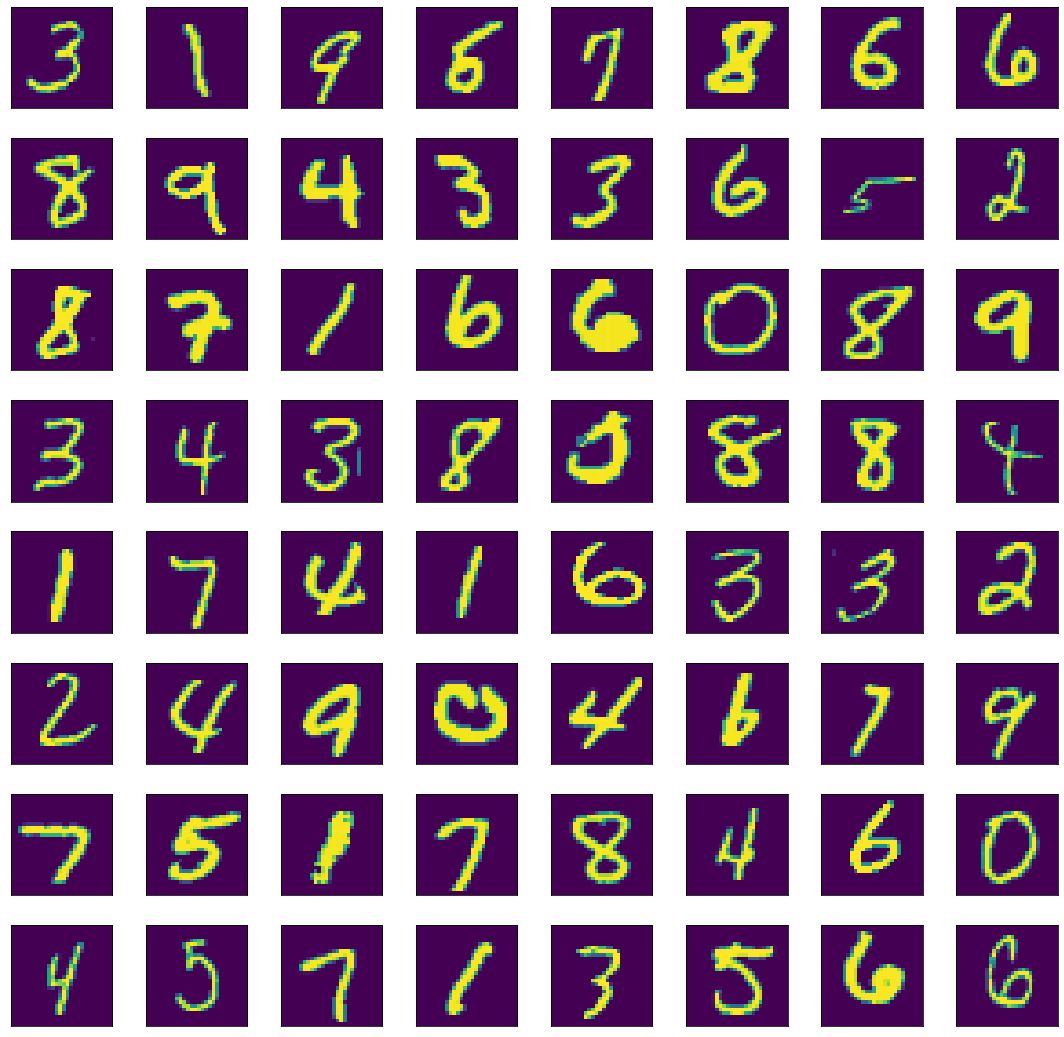

Plotting binarized


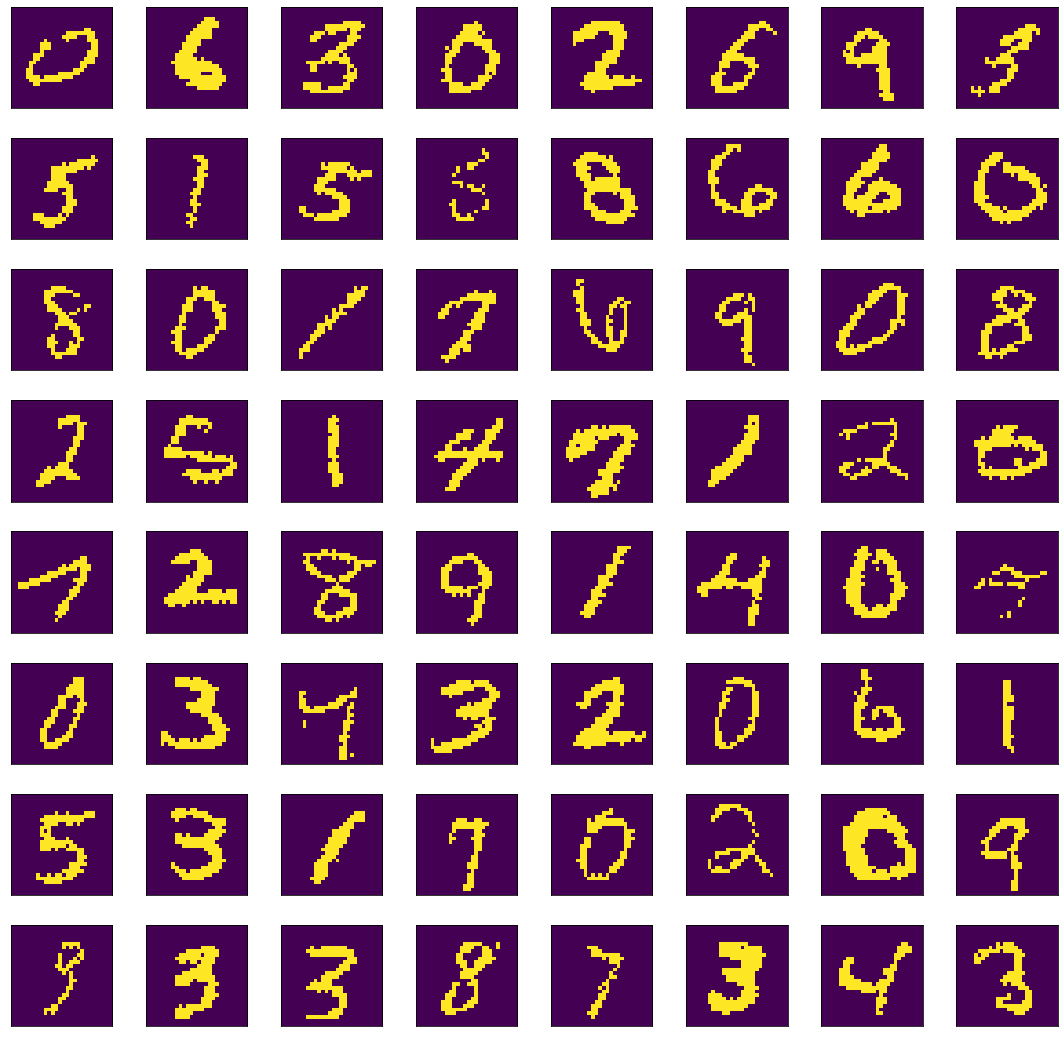

In [19]:
examples = enumerate(train_loader)

# Plot non-binarized
print("Plotting non-binarized")
plot_64(batch=examples)

dset_bin=None

if dataset=="mnist":
    dset_bin, dset_bin_test = importMNIST(binarized=True)
    
if dataset=="fashion":
    dset_bin, dset_bin_test = importFashionMNIST(binarized=True)

bin_loader = create_loader(dset_bin,batch_size)

examples = enumerate(bin_loader)
    
print("Plotting binarized")
plot_64(batch=examples)

## VAE

In [ ]:
# define model and optimizer
mode = "vae"
model = VAE(device, image_channels=image_channels,h_dim=1024,z_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### 2.2.1.2 (Report) 
Generate 64 samples from the untrained model and plot them on a 8 × 8 grid.

Sampling before training


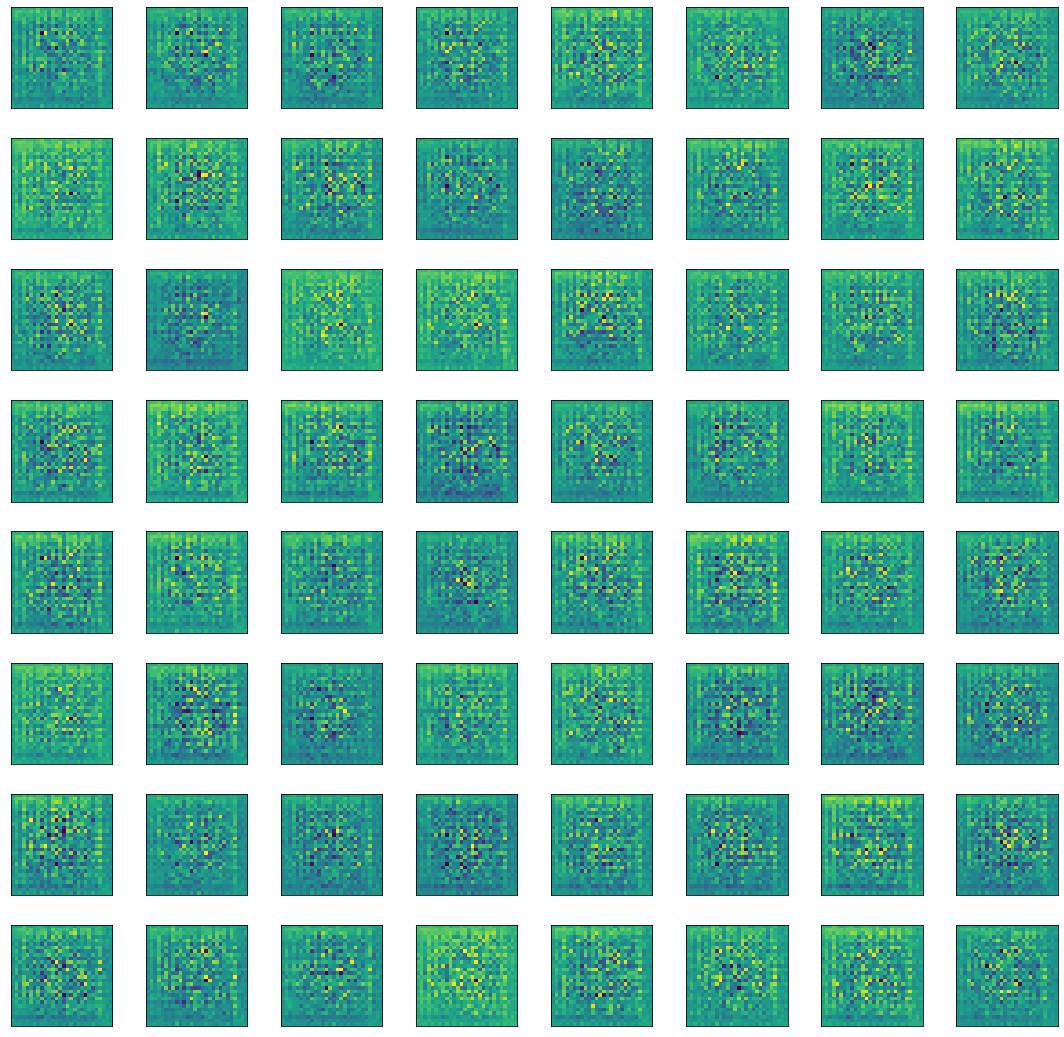

In [ ]:
# Sample before training
print("Sampling before training")
plot_64(model=model, sample=True)

### 2.2.1.3 (Report)
Compute the ELBO of 64 samples from the training set using the untrained model and report the number.

In [ ]:
loader_train = create_loader(dset_bin,batch_size)
examples = enumerate(loader_train)

idx, (samples, targets) = next(examples)
model.eval()
x_recon, mu, logvar = model.forward(samples.to(model.device), [])
elbo, bce, kld = model.loss_fn(x_recon, samples, mu, logvar)
print(f"ELBO: {elbo}")

ELBO: 301305.125


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
epochs = 100

# Train network
run_epochs(mode, model, optimizer, epochs, train_loader, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/100] Loss: 28.769 28.747 0.022
Epoch[2/100] Loss: 17.268 17.246 0.022
Epoch[3/100] Loss: 17.276 17.256 0.020
Epoch[4/100] Loss: 17.344 17.327 0.017
Epoch[5/100] Loss: 16.365 16.348 0.018
Epoch[6/100] Loss: 15.952 15.934 0.018
Epoch[7/100] Loss: 15.613 15.597 0.016
Epoch[8/100] Loss: 16.359 16.342 0.017
Epoch[9/100] Loss: 15.590 15.574 0.016
Epoch[10/100] Loss: 14.905 14.889 0.016
Epoch[11/100] Loss: 15.629 15.614 0.015
Epoch[12/100] Loss: 15.614 15.599 0.015
Epoch[13/100] Loss: 15.086 15.070 0.015
Epoch[14/100] Loss: 14.304 14.289 0.015
Epoch[15/100] Loss: 15.202 15.187 0.015
Epoch[16/100] Loss: 15.012 14.998 0.014
Epoch[17/100] Loss: 15.200 15.185 0.015
Epoch[18/100] Loss: 14.140 14.124 0.015
Epoch[19/100] Loss: 14.222 14.207 0.015
Epoch[20/100] Loss: 14.748 14.734 0.014
Epoch[21/100] Loss: 15.081 15.067 0.014
Epoch[22/100] Loss: 15.888 15.874 0.014
Epoch[23/100] Loss: 15.131 15.117 0.014
Epoch[24/100] Loss: 14.618 14.604 0.015
Epoch[25/100] Loss: 14.574 14.560 0.014
Epoch[26/

### 2.2.2.4 (Report) 
Generate 64 samples from the trained model and plot them on a 8 × 8 grid.

Sampling after training


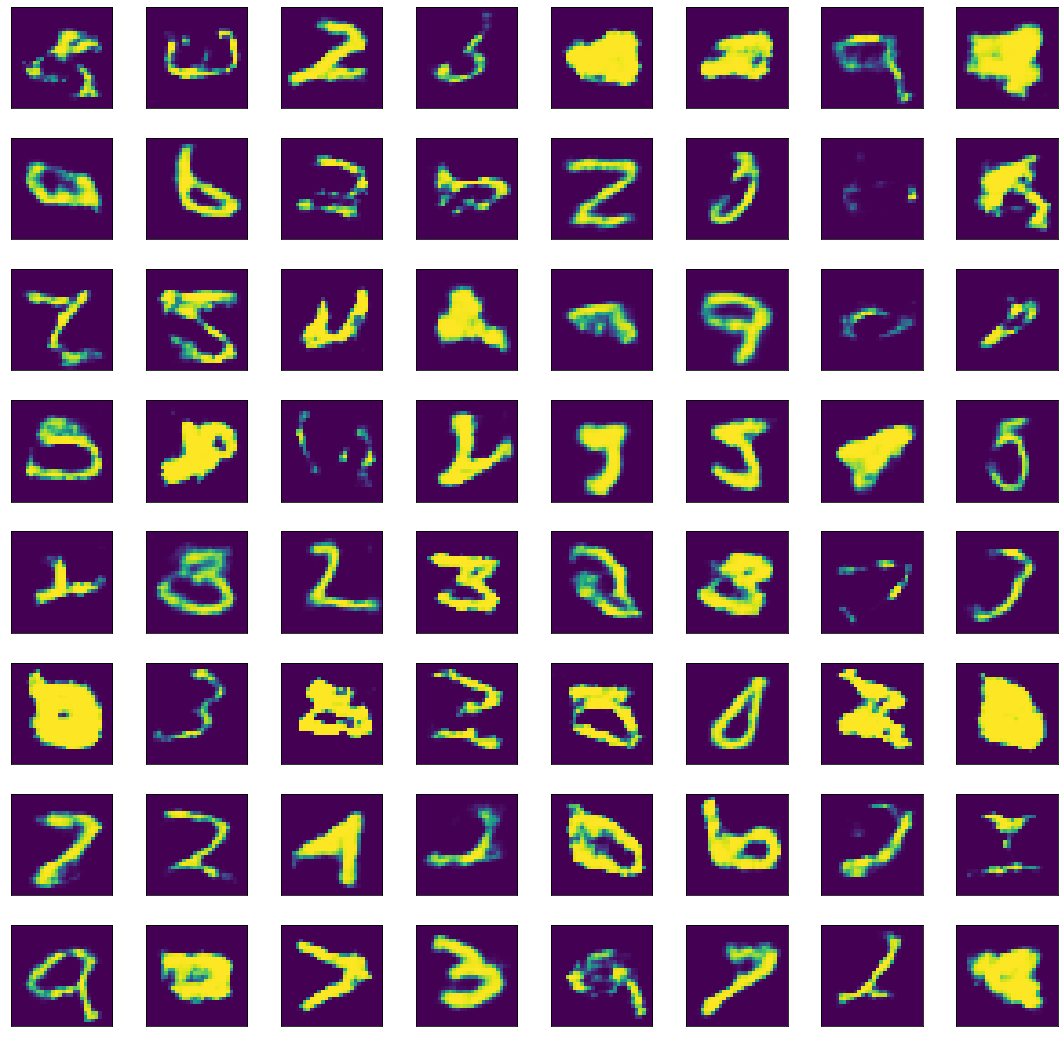

In [ ]:
# Sample after training
print("Sampling after training")
plot_64(model=model, sample=True)

### 2.2.2.5 (Report)
Evaluate the trained model on the test set and report the number.

In [ ]:
loader_test = create_loader(dset_bin_test,batch_size)
examples = enumerate(loader_test)

batch_idx, (example_data, example_targets) = next(examples)

model.eval()
recon_images, mu, logvar = model(example_data.to(device),example_targets)
loss, bce, kld = model.loss_fn(recon_images, example_data, mu, logvar)
to_print = "Loss – ELBO: {:.3f}, BCE: {:.3f}, KLD: {:.3f}".format(loss.data.cpu().numpy().tolist()/batch_size, bce.data.cpu().numpy().tolist()/batch_size, kld.data.cpu().numpy().tolist()/batch_size)
print(to_print)

Loss – ELBO: 77.255, BCE: 77.241, KLD: 0.014


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## M1

In [ ]:
epochs = 100
latent_dim = 8
train_loss = []
train_acc = []
test_loss = []
test_acc = []

In [ ]:
# define model and optimizer
mode = "m1"
model = M1(device, image_channels=1, h_dim=1024, z_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1 of 100
	 Training ...


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


	 Testing ...
Train ELBO: -206.4810
Val ELBO: -150.9696
Epoch 2 of 100
	 Training ...
	 Testing ...
Train ELBO: -128.4718
Val ELBO: -105.7934
Epoch 3 of 100
	 Training ...
	 Testing ...
Train ELBO: -104.0398
Val ELBO: -95.0120
Epoch 4 of 100
	 Training ...
	 Testing ...
Train ELBO: -96.9181
Val ELBO: -90.2874
Epoch 5 of 100
	 Training ...
	 Testing ...
Train ELBO: -93.3249
Val ELBO: -87.2367
Epoch 6 of 100
	 Training ...
	 Testing ...
Train ELBO: -91.0525
Val ELBO: -87.2791
Epoch 7 of 100
	 Training ...
	 Testing ...
Train ELBO: -89.2918
Val ELBO: -84.6657
Epoch 8 of 100
	 Training ...
	 Testing ...
Train ELBO: -87.9038
Val ELBO: -83.2680
Epoch 9 of 100
	 Training ...
	 Testing ...
Train ELBO: -86.8271
Val ELBO: -83.7289
Epoch 10 of 100
	 Training ...
	 Testing ...
Train ELBO: -85.9423
Val ELBO: -82.1428
Epoch 11 of 100
	 Training ...
	 Testing ...
Train ELBO: -85.1240
Val ELBO: -81.5570
Epoch 12 of 100
	 Training ...
	 Testing ...
Train ELBO: -84.5286
Val ELBO: -81.4949
Epoch 13 of 10

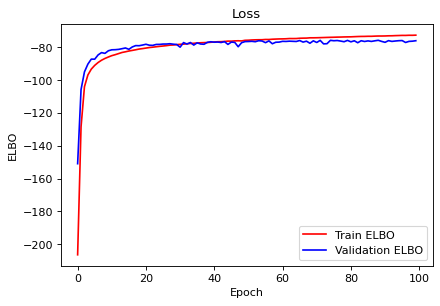

In [ ]:
# train network
train_loss, test_loss = run_epochs(mode, model, optimizer, epochs, train_loader, test_loader, train_loss, test_loss)

# plot loss
plot_loss_m1(train_loss,test_loss)

### 2.3.2 (Report)
Train a classifier on their latent representation. First try a linear classifier and then
experiment with other types of classifiers. Report the accuracies.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Mean acc (train):  1.0
Mean acc (test):  0.7481675091911765


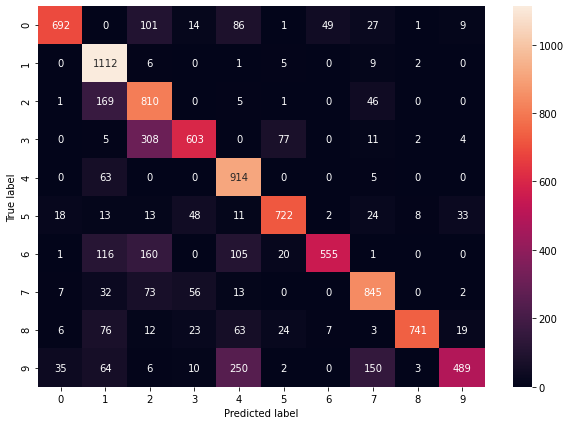

In [ ]:
linearregression_classifier(model, dset_train, dset_test, classes)

Mean acc (train):  0.89
Mean acc (test):  0.09570886948529411


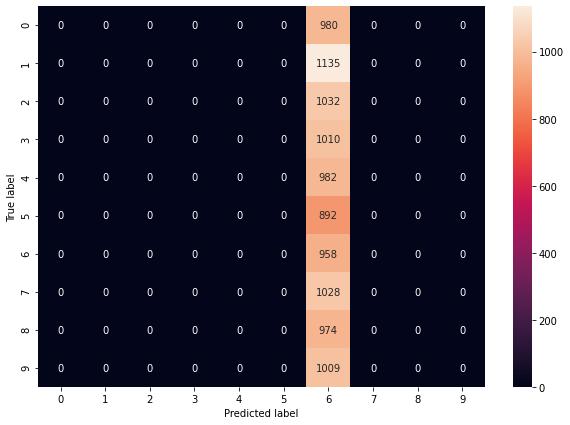

In [ ]:
kneighbors_classifier(model, dset_train, dset_test, classes)

Mean acc (train):  1.0
Mean acc (test):  0.6610696231617647


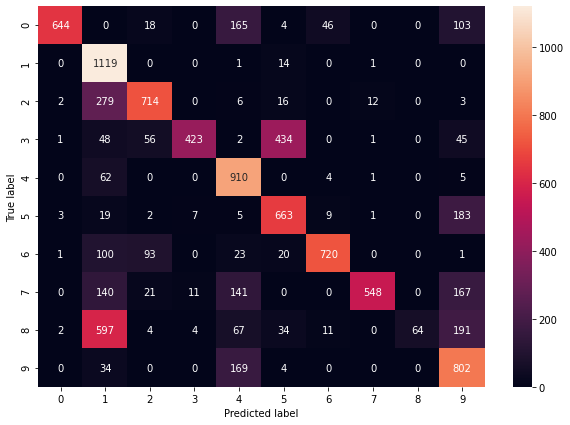

In [ ]:
mlp_classifier(model, dset_train, dset_test, classes)

### 2.3.3 (Report)
Implement some simple baselines: Train a linear classifier or neural network from
scratch using *only* the 100 labeled data points. Report the accuracies.

Mean acc (train):  1.0
Mean acc (test):  0.6715245863970588


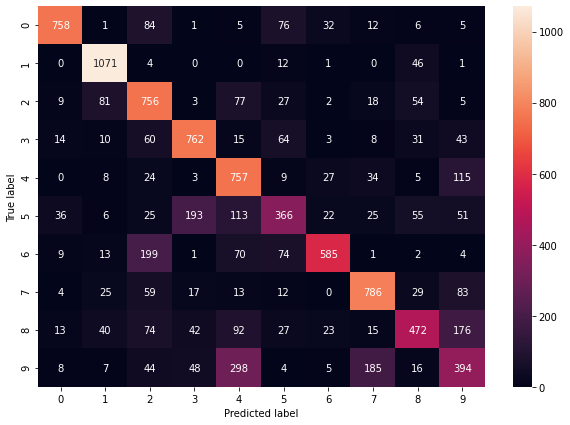

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# training
idx_train_subset = get_target_indexes(dset_train, classes, 10)
X_train = dset_train.data[idx_train_subset]
# insert extra dim for the image channel
X_train = torch.flatten(X_train, start_dim=1).numpy()
y_train = dset_train.targets[idx_train_subset].numpy()

clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
train_acc = sklearn.metrics.accuracy_score(y_train, y_pred)
print("Mean acc (train): ", train_acc)

# testing
loader_test = create_loader(dset_bin_test, batch_size)

test_acc_running = 0.
cm = np.zeros(shape=(len(classes), len(classes)), dtype=np.int16)


for idx, (images, labels) in enumerate(loader_test):
    X_test = torch.flatten(images, start_dim=1).numpy()
    y_test = labels.numpy()

    y_pred = clf.predict(X_test)
    test_acc_batch = sklearn.metrics.accuracy_score(y_test, y_pred)
    test_acc_running += test_acc_batch

    cm_batch = sklearn.metrics.confusion_matrix(
        y_true=y_test, y_pred=y_pred)
    cm += cm_batch

test_acc = test_acc_running / len(loader_test)
print("Mean acc (test): ", test_acc)

df_cm = pd.DataFrame(cm, index=[str(i) for i in classes],
                      columns=[str(i) for i in classes])

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

### Reconstructions and Interpolations

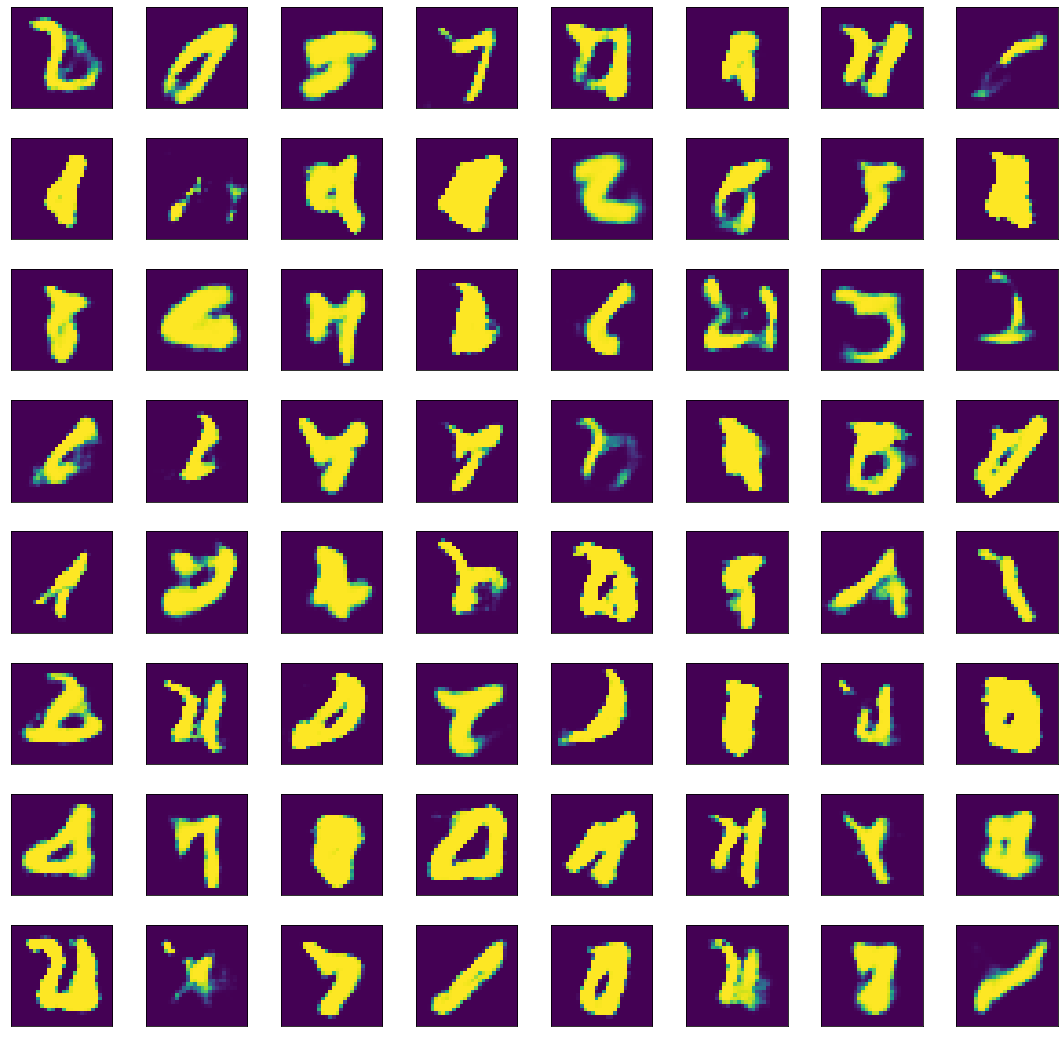

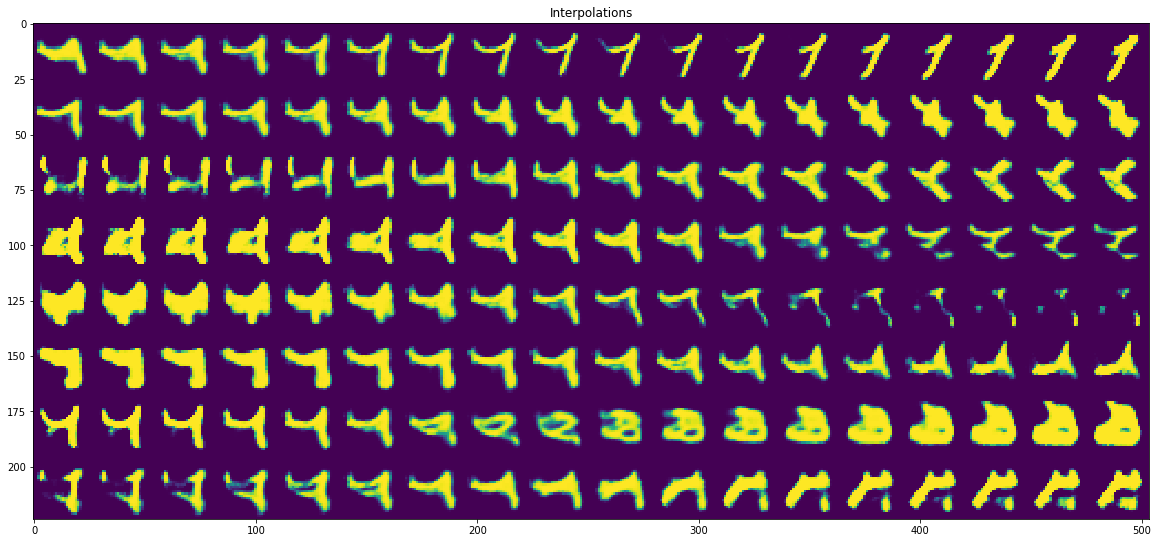

array([2.5462096, 1.9387361, 3.045536 , 2.4589062, 3.2195187, 2.6542225,
       3.465158 , 3.26513  ], dtype=float32)

In [ ]:
# plot reconstructions
plot_64(model=model,sample=True)

# sample model and plot interpolations
z_in = model.sample(batch_size=10,z_out=True)
plot_interpolation_m1(model, z_in=z_in,image_n=0,latent_dim=latent_dim,imsize=28,interpolate_dim=18,std_=3,batch_size=10)


## M2

In [20]:
epochs = 100
latent_dim = 8
train_loss = []
train_acc = []
test_loss = []
test_acc = []

In [21]:
# define model and optimizer
mode = "m2"
model = M2(device, image_channels=image_channels, h_dim=1024, z_dim=latent_dim, num_labels=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


### 2.4.2 (Report) 
Train the model for the same number of epochs as the VAE earlier. Report the
accuracy.

Epoch 1 of 100
	 Training ...


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


	 Testing ...
Train Loss: 472.4409
Val Loss: 387.6683
Train Acc: 0.2119
Val Acc: 0.3361
Epoch 2 of 100
	 Training ...
	 Testing ...
Train Loss: 365.2119
Val Loss: 337.7726
Train Acc: 0.5934
Val Acc: 0.7463
Epoch 3 of 100
	 Training ...
	 Testing ...
Train Loss: 328.9333
Val Loss: 308.8544
Train Acc: 0.7975
Val Acc: 0.8283
Epoch 4 of 100
	 Training ...
	 Testing ...
Train Loss: 305.7442
Val Loss: 289.7437
Train Acc: 0.8560
Val Acc: 0.8839
Epoch 5 of 100
	 Training ...
	 Testing ...
Train Loss: 292.1142
Val Loss: 283.7520
Train Acc: 0.8896
Val Acc: 0.9033
Epoch 6 of 100
	 Training ...
	 Testing ...
Train Loss: 285.6433
Val Loss: 278.5089
Train Acc: 0.9022
Val Acc: 0.9107
Epoch 7 of 100
	 Training ...
	 Testing ...
Train Loss: 284.5804
Val Loss: 280.5530
Train Acc: 0.9087
Val Acc: 0.9221
Epoch 8 of 100
	 Training ...
	 Testing ...
Train Loss: 281.5515
Val Loss: 273.9929
Train Acc: 0.9074
Val Acc: 0.9163
Epoch 9 of 100
	 Training ...
	 Testing ...
Train Loss: 278.6622
Val Loss: 274.0596
Tr

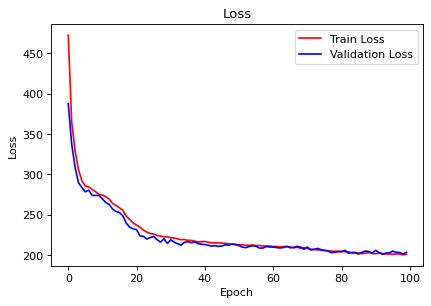

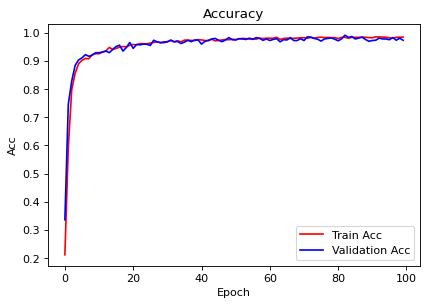

In [22]:
# train network
train_loss, test_loss, train_acc, test_acc = run_epochs(mode, model, optimizer, epochs, train_loader, test_loader, train_loss, test_loss, train_acc, test_acc)

# plot loss
plot_loss_m2(train_loss, test_loss, train_acc, test_acc)

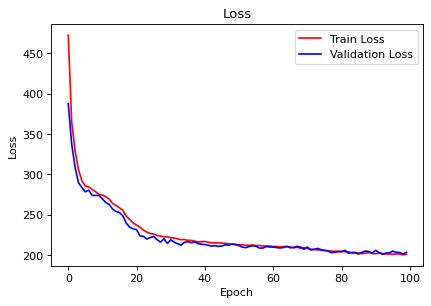

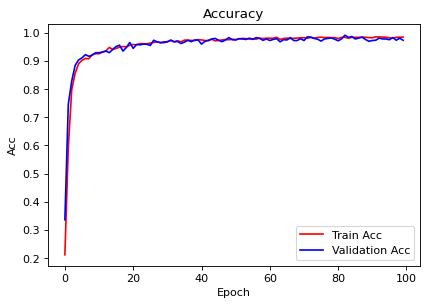

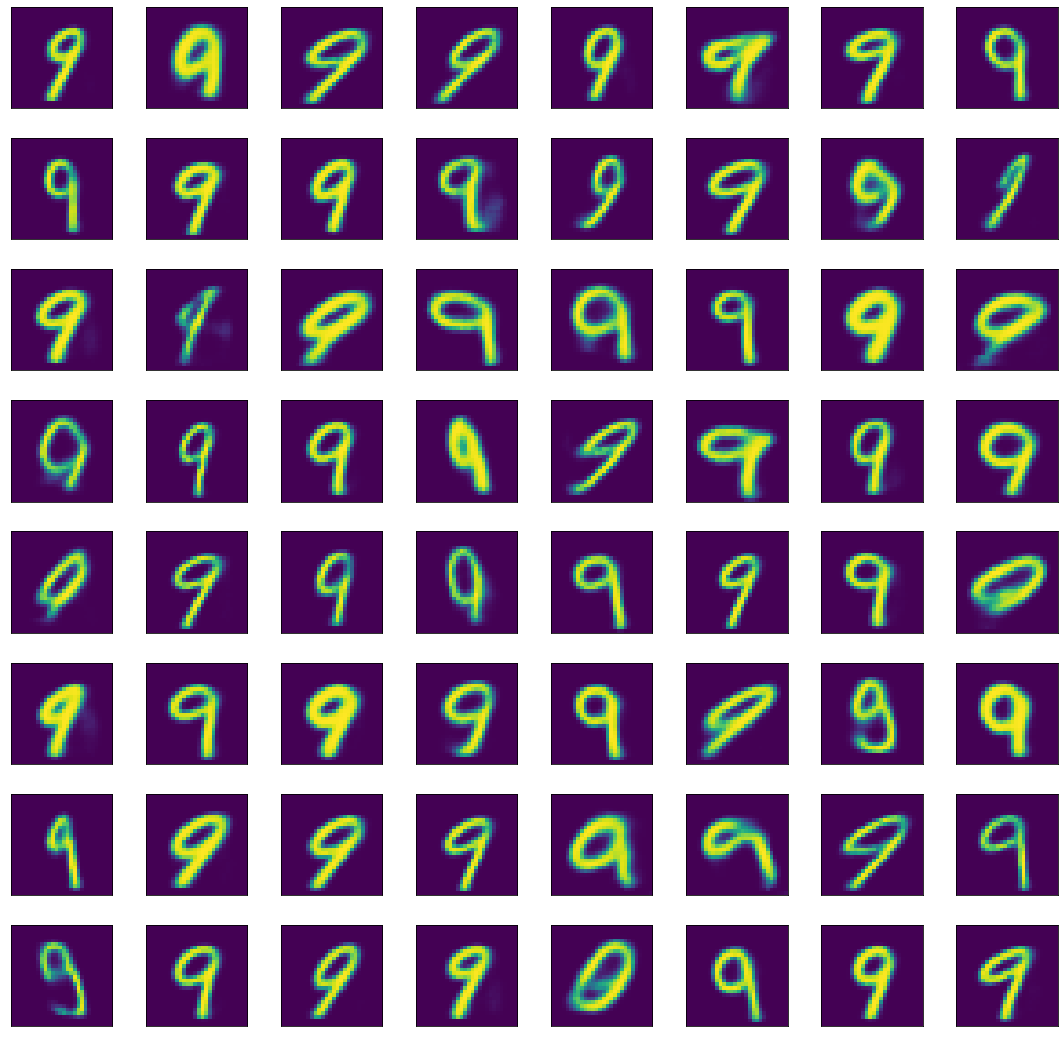

In [23]:
# plot loss
plot_loss_m2(train_loss,test_loss, train_acc, test_acc)

# plot reconstructions
plot_64_m2(model=model, sample=True, y=(torch.ones(64).type(torch.int64)*9))

In [24]:
def make_cm(model, dset):
    loader = torch.utils.data.DataLoader(dset, batch_size=batch_size,
                                              sampler=stratified_sampler(dset.targets, classes))

    acc_running = 0.
    cm = np.zeros(shape=(len(classes), len(classes)), dtype=np.int16)

    model.eval()
    with torch.no_grad():
        for idx, (images, labels) in enumerate(loader):
            X = images.type(torch.float)
            y_test = labels.numpy()

            y_pred = model.classifier(X.to(model.device)).cpu().numpy()
            y_pred = np.argmax(y_pred, axis=1)

            test_acc_batch = sklearn.metrics.accuracy_score(y_test, y_pred)
            acc_running += test_acc_batch

            cm_batch = sklearn.metrics.confusion_matrix(
                y_true=y_test, y_pred=y_pred)
            cm += cm_batch

    acc = acc_running / len(loader)
    print("Mean acc: ", acc)

    df_cm = pd.DataFrame(cm, index=[str(i) for i in classes],
                         columns=[str(i) for i in classes])

    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

Mean acc (train):  0.9845176010430244
Mean acc (val):  0.9732142857142856
Mean acc:  0.985307424081921


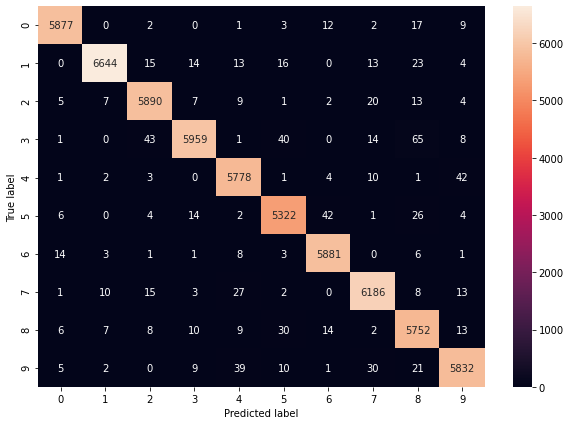

Mean acc:  0.9804285386029411


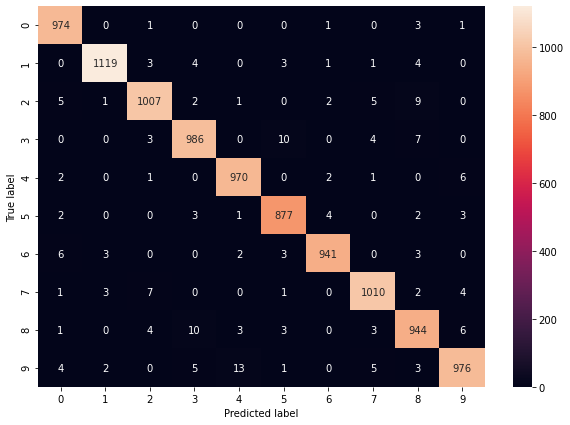

In [25]:
# confusion_matrixes
print("Mean acc (train): ", train_acc[-1])
print("Mean acc (val): ", test_acc[-1])
make_cm(model, dset_train)
make_cm(model, dset_test)

### Sample and interpolations

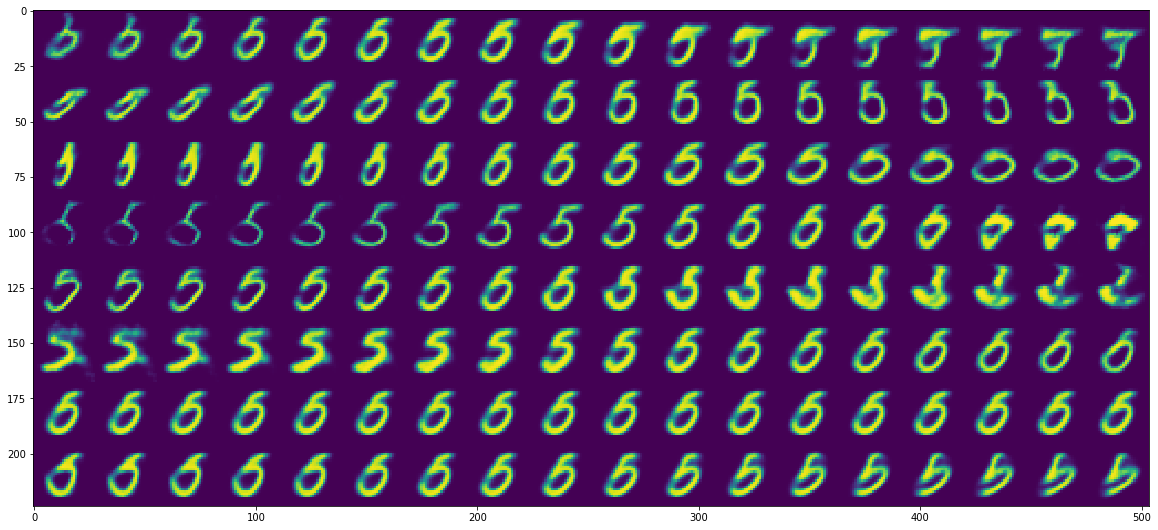

array([2.9000483, 1.9232205, 1.9624792, 4.084686 , 2.6845288, 2.603409 ,
       2.7477138, 2.1885238], dtype=float32)

In [26]:
# sample model and plot interpolations
z_in = model.sample(y=torch.Tensor([0,1,2,3,4,5,6,7,8,9]).type(torch.int64))["z"]
plot_interpolation_m2(model, z_in=z_in,image_n=0,latent_dim=latent_dim,imsize=28,interpolate_dim=18,std_=5,batch_size=10000)
